In [1]:
import os
import re
import nibabel as nib
import numpy as np
import scipy
import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2

from finetune_3D import *
from logistic_regression import *
from models import *
from utils import *

In [11]:
df = load_experiment('/cluster/tufts/hugheslab/eharve06/brain-scan-classifiers/experiments/Pre-Trained_ViT_OASIS-3_MRI_new/n=1300_random_state=2001.csv')
print(open('/cluster/tufts/hugheslab/eharve06/brain-scan-classifiers/experiments/Pre-Trained_ViT_OASIS-3_MRI_new/n=1300_random_state=2001.txt').read())
df.tail()

{'seed': 1001, 'lr': 0.05, 'wd': 1e-05}



,epoch,train_loss,train_BA,train_auroc,val_loss,val_BA,val_auroc,test_loss,test_BA,test_auroc
2995,2996,0.768528,[0.71607677],[0.78946237],0.673887,[0.78101966],[0.80814906],0.727923,[0.64891452],[0.72252374]
2996,2997,0.689274,[0.72446691],[0.79323013],0.617570,[0.7734439],[0.81552007],0.665588,[0.63772049],[0.72139303]
2997,2998,0.674835,[0.71908224],[0.79618859],0.651258,[0.75399263],[0.82739558],0.684702,[0.64122569],[0.7195839]
2998,2999,0.714296,[0.71919138],[0.79608113],0.701651,[0.75337838],[0.82964783],0.731296,[0.63048394],[0.72094075]
2999,3000,0.660973,[0.72046409],[0.7962759],0.631313,[0.75993038],[0.82698608],0.666741,[0.64891452],[0.7195839]


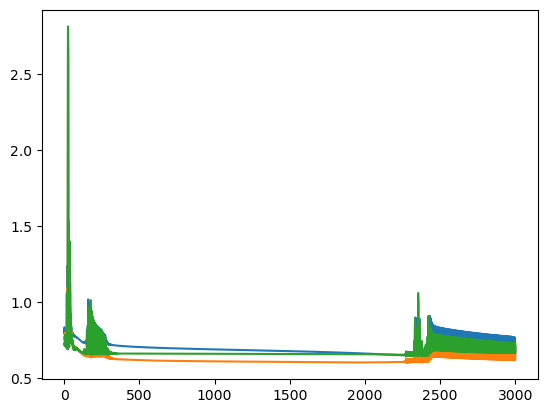

In [12]:
plt.plot(df.epoch.to_list(), df.train_loss.to_list())
plt.plot(df.epoch.to_list(), df.val_loss.to_list())
plt.plot(df.epoch.to_list(), df.test_loss.to_list())

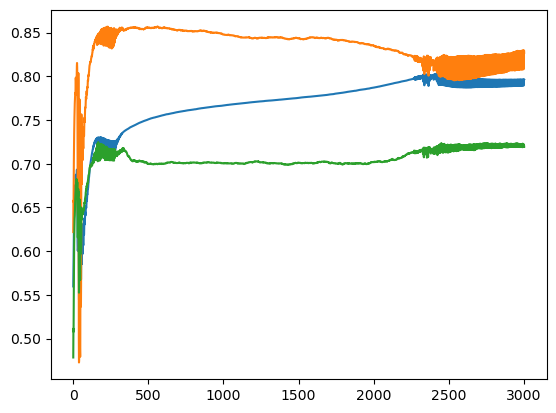

In [13]:
plt.plot(df.epoch.to_list(), np.array(df.train_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.val_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.test_auroc.to_list())[:,0])

In [10]:
val_performance = df.val_auroc.values
averaged_performance = [np.mean(val_performance[index-30:index]) for index in range(30, len(val_performance))]
print(val_performance.shape)
print('best epoch: {}'.format(30+np.argmax(averaged_performance)))
print('val_auroc: {}'.format(df.val_auroc.to_list()[30+np.argmax(averaged_performance)]))
print('test_auroc: {}'.format(df.test_auroc.to_list()[30+np.argmax(averaged_performance)]))

(3000,)
best epoch: 570
val_auroc: [0.85585586]
test_auroc: [0.70013569]


In [77]:
columns = ['n', 'random_state', 'train_BA', 'train_auroc', 'val_BA', 'val_auroc', 'test_BA', 'test_auroc']
df = pd.DataFrame(columns=columns)

#ns = [60, 94, 147, 230, 360, 414, 475, 546]
ns = [60, 94, 147, 230, 360, 414, 475]
random_states = [1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001, 10001, 11001, 12001, 13001, 14001, 15001]
random_states = [1001, 2001, 3001]
experiments_path = '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_mean'
experiments_path = '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/CBI_attention'

for model_index, (n, random_state) in enumerate(itertools.product(ns, random_states)):    
    temp_df = load_experiment('{}/n={}_random_state={}.csv'\
                         .format(experiments_path, n, random_state))
    val_performance = temp_df.val_loss.values
    averaged_performance = [np.mean(val_performance[index-30:index]) for index in range(30, len(val_performance))]
    train_loss, train_BA, train_auroc, val_loss, val_BA, val_auroc, test_loss, test_BA, test_auroc = temp_df.iloc[30+np.argmin(averaged_performance)].to_list()[1:]
    row = [n, random_state, train_BA, train_auroc, val_BA, val_auroc, test_BA, test_auroc]
    df.loc[model_index] = row
    print('best epoch: {}'.format(30+np.argmin(averaged_performance)))
    print('val_loss: {:0.4f}'.format(temp_df.val_loss.to_list()[30+np.argmin(averaged_performance)]))
    print(open('{}/n={}_random_state={}.txt'.format(experiments_path, n, random_state)).read())

best epoch: 152
val_loss: 0.7336
{'seed': 1001, 'lr': 0.01, 'wd': 9.999999999999999e-05}

best epoch: 136
val_loss: 0.7300
{'seed': 2001, 'lr': 0.05, 'wd': 1.0}

best epoch: 544
val_loss: 0.7287
{'seed': 5001, 'lr': 0.05, 'wd': 0.01}

best epoch: 43
val_loss: 0.7393
{'seed': 4001, 'lr': 0.01, 'wd': 0.001}

best epoch: 40
val_loss: 0.7474
{'seed': 3001, 'lr': 0.01, 'wd': 0.01}

best epoch: 122
val_loss: 0.7027
{'seed': 1001, 'lr': 0.05, 'wd': 1.0}

best epoch: 42
val_loss: 0.7418
{'seed': 1001, 'lr': 0.01, 'wd': 0.01}

best epoch: 94
val_loss: 0.7083
{'seed': 3001, 'lr': 0.05, 'wd': 1.0}

best epoch: 73
val_loss: 0.6803
{'seed': 2001, 'lr': 0.05, 'wd': 9.999999999999999e-05}

best epoch: 147
val_loss: 0.6751
{'seed': 1001, 'lr': 0.05, 'wd': 0.001}

best epoch: 37
val_loss: 0.7269
{'seed': 1001, 'lr': 0.05, 'wd': 0.01}

best epoch: 203
val_loss: 0.6430
{'seed': 1001, 'lr': 0.05, 'wd': 9.999999999999999e-05}

best epoch: 999
val_loss: 0.5820
{'seed': 1001, 'lr': 0.01, 'wd': 0.001}

best e

In [78]:
#df.to_csv('./OASIS-3_short_range.csv')
#wmd_df = utils.load_experiment('./Pilot_WMD.csv')
#sbi_df = utils.load_experiment('./Pilot_CBI.csv')
#df = pd.concat([wmd_df, sbi_df], axis=0)
#df = df.groupby(['n', 'random_state']).agg(list).reset_index()
#for column in ['train_BA', 'train_auroc', 'val_BA', 'val_auroc', 'test_BA', 'test_auroc']:
#    df[column] = df[column].apply(lambda item: np.array(item).flatten())
#df.to_csv('./Pilot_short_range.csv')

In [79]:
df

,n,random_state,train_BA,train_auroc,val_BA,val_auroc,test_BA,test_auroc
0,60,1001,[0.93877551],[0.9851577],[0.65336879],[0.60460993],[0.53812057],[0.56205674]
1,60,2001,[0.87234043],[0.90834697],[0.58244681],[0.53546099],[0.51861702],[0.63475177]
2,60,3001,[1.0],[1.0],[0.7358156],[0.7251773],[0.47340426],[0.44503546]
3,94,1001,[0.82678571],[0.87946429],[0.61170213],[0.55496454],[0.57890071],[0.54432624]
4,94,2001,[0.83040541],[0.88851351],[0.60992908],[0.51241135],[0.70478723],[0.62411348]
5,94,3001,[0.79578947],[0.83649123],[0.79875887],[0.7464539],[0.39095745],[0.44858156]
6,147,1001,[0.71239837],[0.77879404],[0.63386525],[0.56560284],[0.6001773],[0.65602837]
7,147,2001,[0.75833333],[0.79567901],[0.73492908],[0.70390071],[0.66134752],[0.71631206]
8,147,3001,[0.89992026],[0.94736842],[0.66489362],[0.68617021],[0.48758865],[0.54078014]
9,230,1001,[0.86117216],[0.92615385],[0.69503546],[0.72340426],[0.6108156],[0.68617021]


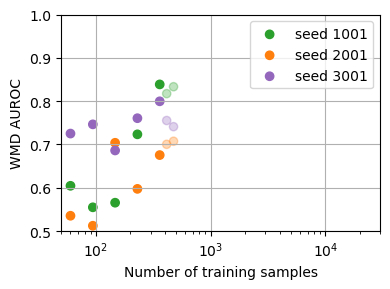

In [80]:
def get_alpha(n):
    if n <= 360:
        return 1.0
    else:
        return 0.3

def plot_experiment(df, labels, random_states=[1001, 2001, 3001]):
    df = df[df.random_state.isin(random_states)]
    colors = ['#2ca02c', '#ff7f0e', '#9467bd', '#1f77b4', '#d62728', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff9896', '#aec7e8', '#ff0000', '#00ff00', '#0000ff']
    ncols = len(labels) if len(labels) < 4 else 4
    nrows = math.ceil(len(labels)/4)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
    for label_index, _ in enumerate(labels):       
        for color, random_state in zip(colors, random_states):
            # Plot data
            temp_df = df[df.random_state==random_state]
            np.array(axs).flatten()[label_index]\
            .scatter(temp_df.n.to_numpy(),
                     np.array(temp_df.val_auroc.to_list())[:,label_index],
                     color = color,
                     alpha=list(map(get_alpha, df.n[df.random_state==random_state].to_list())),
                     label='seed {}'.format(random_state))
        np.array(axs).flatten()[label_index]\
        .set_xlim([50, 30000])
        np.array(axs).flatten()[label_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[label_index]\
        .set_xscale('log')
        np.array(axs).flatten()[label_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[label_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[label_index]\
        .legend()
        np.array(axs).flatten()[label_index]\
        .grid()
    fig.tight_layout()
    plt.show()
    
plot_experiment(df, ['WMD'], random_states)

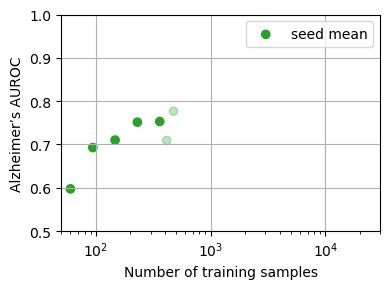

In [71]:
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.array([np.mean(x)]))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()
plot_experiment(df, ['Alzheimer’s'], ['mean'])

In [22]:
df

,n,random_state,train_BA,train_auroc,val_BA,val_auroc,test_BA,test_auroc
0,60,mean,"[[0.93413729], [0.87234043], [1.0], [0.8274582...","[[0.98330241], [0.90834697], [1.0], [0.8070500...","[[0.6214539], [0.59308511], [0.68439716], [0.5...","[[0.59574468], [0.54432624], [0.62943262], [0....","[[0.53812057], [0.52925532], [0.41134752], [0....",[0.6160756500000001]
1,94,mean,"[[0.91428571], [0.78986486], [0.88807018], [0....","[[0.92767857], [0.8472973], [0.94807018], [0.7...","[[0.6427305], [0.63031915], [0.72429078], [0.5...","[[0.59042553], [0.57624113], [0.71985816], [0....","[[0.6108156], [0.69326241], [0.50443262], [0.5...",[0.6265957446666667]
2,147,mean,"[[0.73424797], [0.98148148], [0.88476874], [0....","[[0.78421409], [0.99845679], [0.93567251], [0....","[[0.62322695], [0.68617021], [0.69503546], [0....","[[0.56560284], [0.69680851], [0.70212766], [0....","[[0.6001773], [0.68617021], [0.4751773], [0.46...",[0.6719858160000001]
3,230,mean,"[[0.91282051], [0.76544944], [0.92650037], [0....","[[0.95545788], [0.83923941], [0.97836052], [0....","[[0.70478723], [0.73492908], [0.72695035], [0....","[[0.75], [0.62588652], [0.73404255], [0.409574...","[[0.67287234], [0.70390071], [0.50797872], [0....",[0.663120568]
4,360,mean,"[[0.89177489], [0.75752947], [0.85416667], [0....","[[0.94954649], [0.81051024], [0.9186439], [0.7...","[[0.86258865], [0.73670213], [0.70656028], [0....","[[0.86524823], [0.70390071], [0.7251773], [0.4...","[[0.65336879], [0.6320922], [0.49734043], [0.5...",[0.6768321513333333]
5,414,mean,"[[0.86697525], [0.7269683], [0.74063326], [0.6...","[[0.9334215], [0.77985659], [0.82026888], [0.7...","[[0.84042553], [0.71453901], [0.7570922], [0.5...","[[0.85638298], [0.68262411], [0.71985816], [0....","[[0.62056738], [0.67287234], [0.59929078], [0....",[0.6855791966666668]
6,475,mean,"[[0.84501429], [0.71030382], [0.7276905], [0.6...","[[0.91639182], [0.77447772], [0.80821469], [0....","[[0.85106383], [0.73670213], [0.7464539], [0.5...","[[0.87943262], [0.69858156], [0.71985816], [0....","[[0.64184397], [0.70567376], [0.56737589], [0....",[0.6810874726666666]


In [42]:
columns = ['max_slices', 'random_state', 'train_BA', 'train_auroc', 'val_BA', 'val_auroc', 'test_BA', 'test_auroc']
df = pd.DataFrame(columns=columns)

random_states = [1001, 2001, 3001, 4001, 5001]
random_states = [1001, 2001, 3001, 4001, 5001, 6001, 7001, 8001, 9001, 10001, 11001, 12001, 13001, 14001, 15001]
ns = [500]
slices = [6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300]

for n, random_state, max_slices in itertools.product(ns, random_states, slices):
    experiments_path = '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/varying_max_slices/WMD/max_slices={}'.format(max_slices)
    temp_df = load_experiment('{}/n={}_random_state={}.csv'\
                         .format(experiments_path, n, random_state))
    val_performance = temp_df.val_auroc.values
    averaged_performance = [np.mean(val_performance[index-30:index]) for index in range(30, len(val_performance))]
    train_loss, train_BA, train_auroc, val_loss, val_BA, val_auroc, test_loss, test_BA, test_auroc = temp_df.iloc[30+np.argmax(averaged_performance)].to_list()[1:]
    row = [max_slices, random_state, train_BA, train_auroc, val_BA, val_auroc, test_BA, test_auroc]
    df.loc[df.shape[0]] = row
    print('best epoch: {}'.format(30+np.argmax(averaged_performance)))
    print('val_loss: {:0.4f}'.format(temp_df.val_loss.to_list()[30+np.argmax(averaged_performance)]))
    print(open('{}/n={}_random_state={}.txt'.format(experiments_path, n, random_state)).read())
# Average across seeds
df = df.groupby('max_slices').agg(lambda x: list(x))
columns = ['test_auroc', 'train_auroc', 'val_auroc']
for column in columns:
    df['{}_min'.format(column)] = df[column].apply(lambda item: np.min(item))
    df['{}_max'.format(column)] = df[column].apply(lambda item: np.max(item))
    df[column] = df[column].apply(lambda item: np.mean(item))
df = df.reset_index()   

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/varying_max_slices/WMD/max_slices=6/n=500_random_state=1001.csv'

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.plot(df.max_slices, df.val_auroc, color='#1f77b4', label='Validation', linestyle='-', marker='o')
#ax.fill_between(df.max_slices, df.val_auroc_min, df.val_auroc_max, alpha=0.1, color='#1f77b4')
ax.plot(df.max_slices, df.test_auroc, color='#ff7f0e', label='Test', linestyle='-', marker='o')
#ax.fill_between(df.max_slices, df.test_auroc_min, df.test_auroc_max, alpha=0.1, color='#ff7f0e')
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Maximum numer of slices')
ax.set_ylabel('WMD AUROC')
ax.grid(), ax.legend()
fig.tight_layout()
plt.show()